# Karpathy Makemore using Neural Nets
This is the second part of the [First Makemore Lesson](https://www.youtube.com/watch?v=PaCmpygFfXo) which starts around 1 hr in. AK has already built a bigram model for the names app, and is now extending it using torch arrays and autodiff.

In [17]:
using Plots
using Flux
using Flux: onehotbatch
using Statistics


Read in the name list

In [5]:
f = open("names.txt","r")
    s = read(f,String)
close(f)
words = split(s,"\n")
words[1:10]

10-element Vector{SubString{String}}:
 "emma"
 "olivia"
 "ava"
 "isabella"
 "sophia"
 "charlotte"
 "mia"
 "amelia"
 "harper"
 "evelyn"

Make character mapping arrays

In [6]:
chars = ".abcdefghijklmnopqrstuvwxyz"
stoi = Dict( s => i for (i,s) in enumerate(chars))
itos = Dict( i => s for (i,s) in enumerate(chars))


Dict{Int64, Char} with 27 entries:
  5  => 'd'
  16 => 'o'
  20 => 's'
  12 => 'k'
  24 => 'w'
  8  => 'g'
  17 => 'p'
  1  => '.'
  19 => 'r'
  22 => 'u'
  23 => 'v'
  6  => 'e'
  11 => 'j'
  9  => 'h'
  14 => 'm'
  3  => 'b'
  7  => 'f'
  25 => 'x'
  4  => 'c'
  ⋮  => ⋮

Parse the names into a neural net style of inputs and outputs.

In [8]:
xs, ys = [], []
for word in words[1:1]
    chs = vcat('.',collect(word),'.')
    for (ch1,ch2) in zip(chs,chs[2:end])
        ix1,ix2 = stoi[ch1],stoi[ch2]
        push!(xs,ix1)
        push!(ys,ix2)
    end
end

Use `onehot` encoding to encode the inputs. The transpose is needed below because of the standard Julia vert vs horiz vector confusion.

In [9]:
xenc = onehotbatch(xs,1:27)'

5×27 adjoint(OneHotMatrix(::Vector{UInt32})) with eltype Bool:
 1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  …  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅

Display the encoded matrix for ".emma"

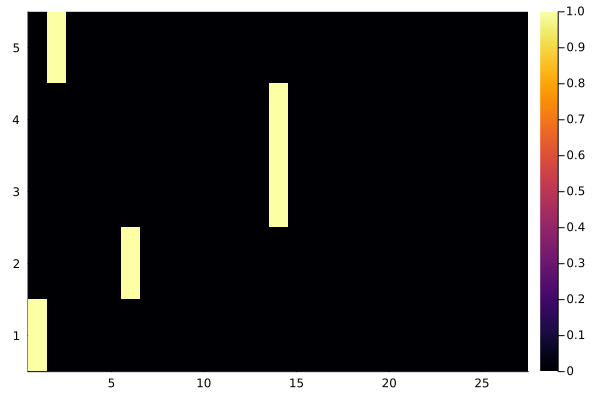

In [10]:
heatmap(xenc)

Create a random set of weights and multiply by the encoded inputs.

Flux uses bools for onehot encoding.
Doesn't seem like I have to worry about it:


In [11]:
W = randn(27,27)
logits = xenc*W # logits = log-counts

5×27 Matrix{Float64}:
  0.188753    1.0612     0.307647   …   0.391094    0.417205  0.309932
  0.0659744  -0.281496  -1.03105        0.530494    0.224938  0.379494
  0.941239    1.69728    0.0106933     -0.725602    0.245361  0.554945
  0.941239    1.69728    0.0106933     -0.725602    0.245361  0.554945
 -0.710154   -0.892073   0.989695       0.0927719  -0.944436  0.437263

Need to get outputs as probabilities, which should be 
positive and sum to one. Interpret these outputs as 
log-counts. We want to exponentiate and then normalize
these to get probs. This is called softmax.

In [12]:
probs = exp.(logits)
for i in 1:size(probs)[1]
    probs[i,:] /= sum(probs[i,:])
end

At 1:29 in video. Looking in detail at one example .emma.

In [22]:
nlls = zeros(Float64,5)
nll = 0
for i in 1:5
    x = xs[i]
    y = ys[i]
    println("--------")
    println("bigram example $i: $(itos[i]) $(itos[y]) indices $x, $y")
    println("input to the neural net: $x")
    println("output probabilities from neural net: $probs")
    println("label of actual next character: $y")
    p = probs[i,y]
    println("probability assigned by the net to the next char: $p")
    logp = log(p)
    println("log likelihood $logp")
    nll = -logp
    println("negative log likelihood: $nll")
    nlls[i] = nll
end
println("========")
println("average neg log likelihood, i.e. loss: $(mean(nll))")

--------
bigram example 1: . e indices 1, 6
input to the neural net: 1
output probabilities from neural net: [0.03131987053118253 0.07494113670035947 0.035274027456140014 0.10709618565909802 0.10267703481156569 0.04044289622702346 0.052008960744904305 0.07655648348797173 0.005339284198506582 0.0205533567099131 0.010490764802716896 0.009125333005767186 0.0653009498298325 0.01436368261706831 0.006014288244594878 0.012601030234889348 0.012471035425917537 0.031238784390525184 0.048408250494450175 0.01731337114625953 0.011531954518652967 0.057005799692414295 0.0031496034469306006 0.04171914112699551 0.038343844294663997 0.039358210824678566 0.03535471937697767; 0.017754899281629936 0.01254335040645741 0.005927718582853019 0.21167886594308535 0.10433857290139158 0.03636205313748552 0.015778346056590998 0.0036389794614507757 0.007987470971988663 0.039361591801319484 0.015055127677801755 0.007868372679072385 0.009316648359825633 0.0078076038189947876 0.010003067367074217 0.11799828190088395 0.

He's now doing manual optimization of the simple linear net.
I'm not going to do all that.


There's something nice about how torch has both the ability to 
create arrays and to apply networks and functions. I like the 
fact that Flux is cleaner and just uses Julia arrays, but I 
haven't found the analogous capability in Flux.



The problem with this (makemore names) example is that we don't really know
when we're doing a good job, unlike MNIST or linear regression.


2.0